# Import Libraries

In [1]:
import numpy as np
import pandas as pd 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras import utils  # to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cv2

In [6]:
import seaborn as sns
sns.set(color_codes=True)
import warnings
warnings.filterwarnings("ignore")

# Define Constatnts

In [2]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [3]:
filenames=os.listdir("train-20231122/train")
categories=[]
for filename in filenames:
    category=filename.split(".")[0]
    if category=="dog":
        categories.append(1)
    else:
        categories.append(0)
df=pd.DataFrame({"filename":filenames,"category":categories})

In [4]:
df.sample(5)

,filename,category
287,dog.176.jpg,1
176,cat.77.jpg,0
390,dog.89.jpg,1
196,cat.95.jpg,0
159,cat.61.jpg,0


<Axes: >

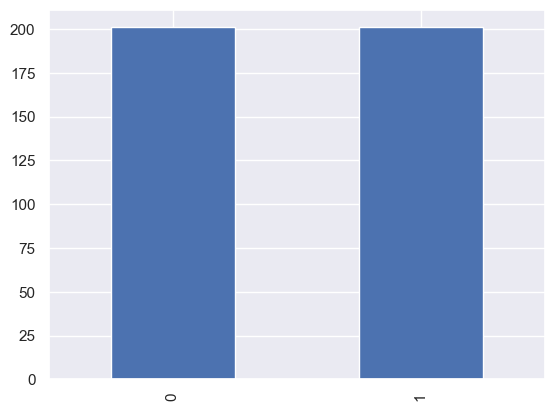

In [9]:
df['category'].value_counts().plot.bar()

#### From our data we have 12000 cats and 12000 dogs

# See sample image

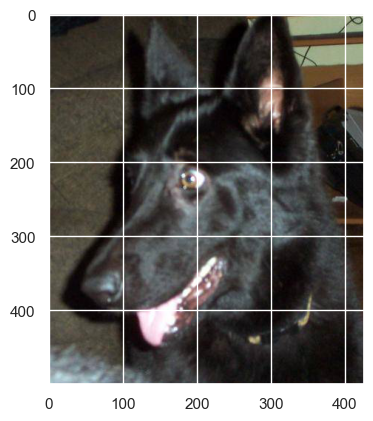

In [11]:
sample = random.choice(filenames)
image = load_img("train-20231028T125340Z-001/train/"+sample)
plt.imshow(image)

# Build Model

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 64)        2

# Callbacks

In [13]:
earlystop = EarlyStopping(patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

# Prepare Data

In [14]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [15]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<Axes: >

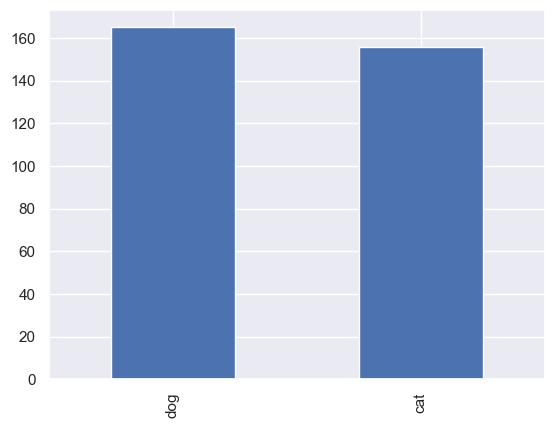

In [16]:
train_df['category'].value_counts().plot.bar()

<Axes: >

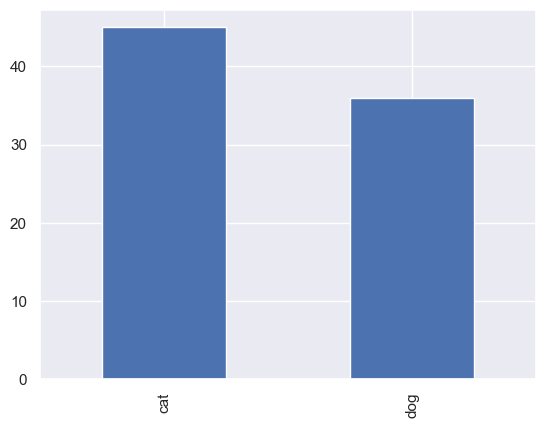

In [17]:
validate_df['category'].value_counts().plot.bar()

In [20]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

# Training Generator

In [22]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "train-20231122/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 321 validated image filenames belonging to 2 classes.


# Validation Generator

In [23]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "train-20231122/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 81 validated image filenames belonging to 2 classes.


# See How Generator works

In [24]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "train-20231122/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


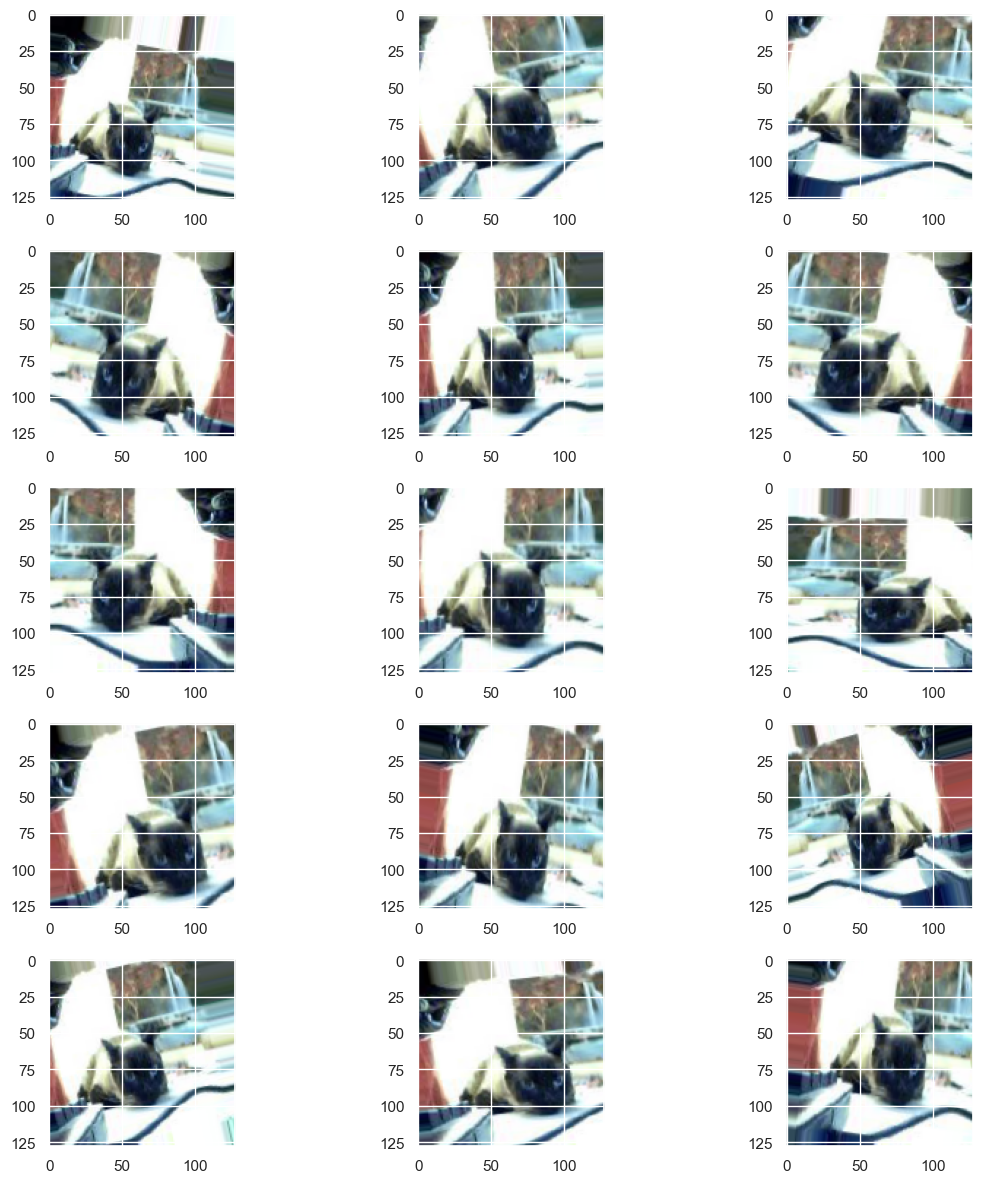

In [25]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [26]:
epochs=3 if FAST_RUN else 50
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)
model.save("model.h5")

Epoch 1/50
21/21 [==============================] - 9s 407ms/step - loss: 1.8095 - accuracy: 0.5719 - val_loss: 2.6661 - val_accuracy: 0.5467 - lr: 0.0010
Epoch 2/50
21/21 [==============================] - 5s 252ms/step - loss: 1.3444 - accuracy: 0.5425 - val_loss: 1.7230 - val_accuracy: 0.5600 - lr: 0.0010
Epoch 3/50
21/21 [==============================] - 5s 249ms/step - loss: 1.1767 - accuracy: 0.5850 - val_loss: 1.7689 - val_accuracy: 0.5733 - lr: 0.0010
Epoch 4/50
21/21 [==============================] - 5s 251ms/step - loss: 1.1296 - accuracy: 0.6242 - val_loss: 2.0170 - val_accuracy: 0.5467 - lr: 0.0010
Epoch 5/50
21/21 [==============================] - ETA: 0s - loss: 1.0687 - accuracy: 0.5752
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
21/21 [==============================] - 5s 248ms/step - loss: 1.0687 - accuracy: 0.5752 - val_loss: 2.9497 - val_accuracy: 0.5467 - lr: 0.0010
Epoch 6/50
21/21 [==============================] - 5s 252ms/step 

# Visualize Training

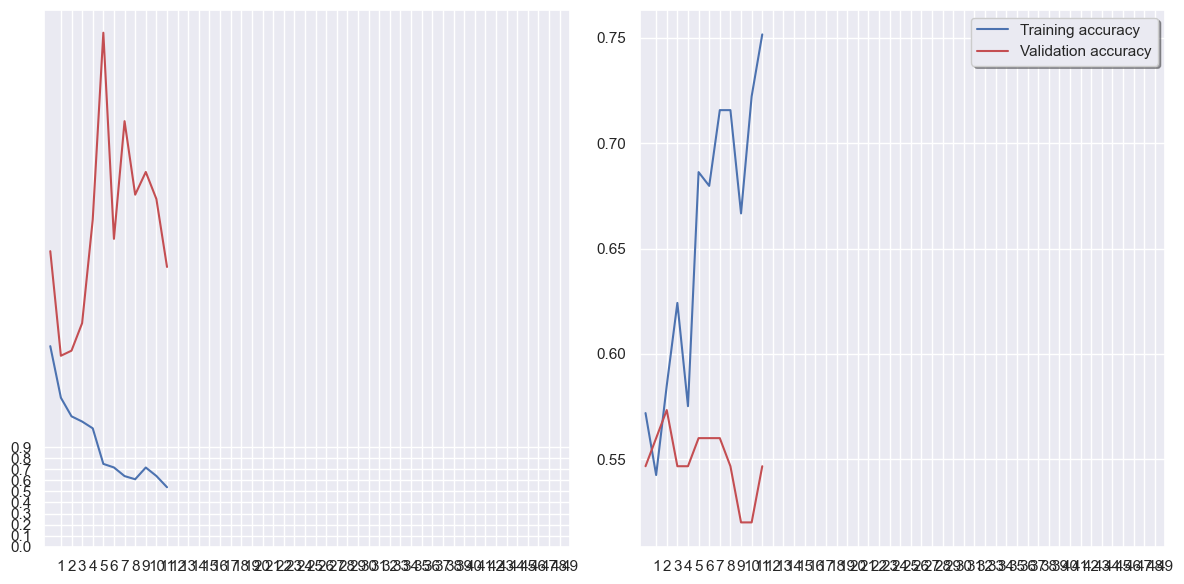

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [29]:
for i in range(10):
    all_test_images = os.listdir("test-20231122/test")
    random_image = random.choice(all_test_images)
    img = cv2.imread(f'test-20231122/test/{random_image}')
    img = cv2.resize(img,(IMAGE_HEIGHT,IMAGE_WIDTH))
    
    org = img.copy()
    img = img.reshape(1,128,128,3)
    
    pred = model.predict(img)
    print(['cat','dog'][int(pred[0][0])])
    cv2.imshow('Live predictions',org)
    cv2.waitKey(0)
cv2.destroyAllWindows()

1/1 [==============================] - 0s 36ms/step
dog
1/1 [==============================] - 0s 39ms/step
dog
1/1 [==============================] - 0s 35ms/step
dog
1/1 [==============================] - 0s 34ms/step
dog
1/1 [==============================] - 0s 47ms/step
dog
1/1 [==============================] - 0s 37ms/step
dog
1/1 [==============================] - 0s 46ms/step
dog
1/1 [==============================] - 0s 34ms/step
dog
1/1 [==============================] - 0s 40ms/step
dog
1/1 [==============================] - 0s 45ms/step
dog
